In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

In [17]:
main_data = pd.read_csv('data.csv')
food_relationship = pd.read_csv('food_hierarchy.csv')

In [18]:
Q1 = main_data['symptom_value'].quantile(0.25)
Q3 = main_data['symptom_value'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
main_data1 = main_data[(main_data['symptom_value'] >= lower_bound) & (main_data['symptom_value'] <= upper_bound)]

<ipython-input-19-72c612a922be>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_data1['symptom_value_log1p'] = np.log1p(main_data1['symptom_value'])


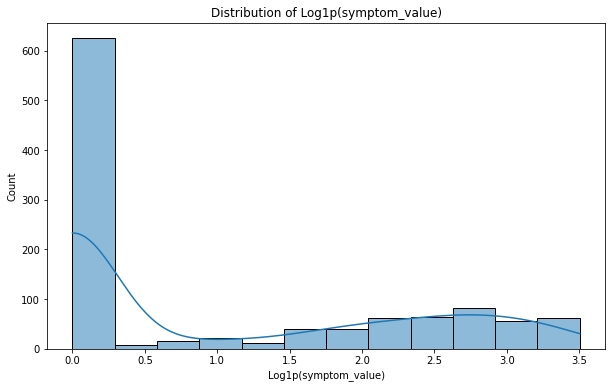

In [19]:
main_data1['symptom_value_log1p'] = np.log1p(main_data1['symptom_value'])

# Check the distribution of the transformed target variable using a histogram or kernel density plot
plt.figure(figsize=(10, 6))
sns.histplot(main_data1['symptom_value_log1p'], kde=True)
plt.xlabel('Log1p(symptom_value)')
plt.title('Distribution of Log1p(symptom_value)')
plt.show()

In [20]:
X = main_data1.drop(columns=['symptom_value_log1p'])
y = main_data1['symptom_value_log1p']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
models = {'Linear Regression': lr, 'KNN': knn, 'XGBoost': xgb}

for name, model in models.items():
    if name == 'KNN':
        y_pred = model.predict(X_test_scaled)
    else:
        y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} R^2 Score: {r2:.4f}")


Linear Regression R^2 Score: 0.8618
KNN R^2 Score: 0.5837
XGBoost R^2 Score: 0.9998


In [25]:
def cross_val(model, X, y, n_splits=5, scaled=False):
    if scaled and isinstance(model, KNeighborsRegressor):
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    cv_scores = cross_val_score(model, X, y, cv=n_splits, scoring='r2')
    return np.mean(cv_scores), np.std(cv_scores)

for name, model in models.items():
    mean_r2, std_r2 = cross_val(model, X, y, n_splits=5, scaled=(name == 'KNN'))
    print(f"{name} Cross-Validation R^2 Score: {mean_r2:.4f} ± {std_r2:.4f}")

Linear Regression Cross-Validation R^2 Score: 0.8616 ± 0.0154
KNN Cross-Validation R^2 Score: 0.5968 ± 0.0616
XGBoost Cross-Validation R^2 Score: 0.9998 ± 0.0000


In [26]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'min_child_weight': [1, 2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
}


In [27]:
xgb_model = XGBRegressor()
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [28]:
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500],
                                        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1]},
                   random_state=42, verbose=2)

In [29]:
print(random_search.best_params_)
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)


{'subsample': 1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0, 'colsample_bytree': 1}


In [31]:
best_xgb_model = XGBRegressor(subsample=1,
                                   n_estimators=100,
                                   min_child_weight=2,
                                   max_depth=4,
                                   learning_rate=0.15,
                                   gamma=0,
                                   colsample_bytree=1)

best_xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [32]:
y_pred = best_xgb_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"{name} R^2 Score: {r2:.4f}")

XGBoost R^2 Score: 0.9999


In [33]:
best_xgb_model.best_ntree_limit

100

In [34]:
best_xgb_model.save_model("best_xgb_model.json")

## Session Info - sam

In [35]:
!python --version
!pip install session-info
import session_info

Python 3.9.16
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 3.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=8613548ec1ce10a3a03a3da643c533b5eb53ed40aa795ed21792b76d936bd701
  Stored in directory: /root/.cache/pip/wheels/d4/fc/2e/00ca60bac7954b84907efd41baa9b4853500eaeec4228410c6
Successfully built session-info


In [36]:
session_info.show()

In [39]:
!pip freeze > requirements.txt